# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load data

In [ ]:
ROBOT_PATH = "Robot_Info.csv"
PRIORITY_PATH = "Management_Priority.xlsx"

# Output folder for figures / exports
OUT_DIR = "/mnt/data/autonomousshipment_part2_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

robots_raw = pd.read_csv(ROBOT_PATH)
robots_raw.head()

,Robot_Prototype,Alpha,Bravo,Charlie,Delta,Echo,Foxtrot,Gamma
0,Carrying Capacity,35,50,50,40,55,70,55
1,Battery Size,11,6,9,12,10,9,10
2,Speed,15,15,15,25,15,15,18
3,Mobility,5,4,3,4,2,1,3
4,Aesthetic,10,6,6,3,6,7,9


# Basic data exploration

In [ ]:
print("Shape:", robots_raw.shape)

Shape: (7, 8)


In [ ]:
print("\nColumns:", robots_raw.columns.tolist())


Columns: ['Robot_Prototype', 'Alpha', 'Bravo', 'Charlie', 'Delta', 'Echo', 'Foxtrot', 'Gamma']


In [ ]:
print("\nMissing values per column:")
display(robots_raw.isna().sum())


Missing values per column:


,0
Robot_Prototype,0
Alpha,0
Bravo,0
Charlie,0
Delta,0
Echo,0
Foxtrot,0
Gamma,0


In [ ]:
print("\nData types:")
display(robots_raw.dtypes)


Data types:


,0
Robot_Prototype,object
Alpha,int64
Bravo,int64
Charlie,int64
Delta,int64
Echo,int64
Foxtrot,int64
Gamma,int64


In [ ]:
print("\nDuplicate prototypes:", robots_raw["Robot_Prototype"].duplicated().sum())


Duplicate prototypes: 0


# Data preparation

In [ ]:
robots_transformed = robots_raw.set_index('Robot_Prototype').T
robots_transformed.index.name = 'Robot_Prototype'
robots = robots_transformed.reset_index()

expected_cols = [
    "Robot_Prototype",
    "Carrying Capacity",
    "Battery Size",
    "Speed",
    "Mobility",
    "Aesthetic",
    "Cost Per Unit",
    "Reliability"
]

missing = [c for c in expected_cols if c not in robots.columns]
if missing:
    raise ValueError(f"Robot_Info.csv missing expected columns: {missing}")

# Coerce numeric for all criteria columns
criteria = expected_cols[1:]

for c in criteria:
    robots[c] = pd.to_numeric(robots[c], errors="coerce")

# Show any coercion-created missing values
print("Missing after numeric coercion:")
display(robots[criteria].isna().sum())

Missing after numeric coercion:


,0
Robot_Prototype,
Carrying Capacity,0
Battery Size,0
Speed,0
Mobility,0
Aesthetic,0
Cost Per Unit,0
Reliability,0


In [ ]:
# If missing values exist, decide how to handle (here: raise to avoid silent bias)
if robots[criteria].isna().any().any():
    raise ValueError("Found missing/non-numeric values after coercion. Please inspect and decide imputation rules.")

# Set prototype as index for analysis
df = robots.set_index("Robot_Prototype")[criteria]
display(df)

Robot_Prototype,Carrying Capacity,Battery Size,Speed,Mobility,Aesthetic,Cost Per Unit,Reliability
Robot_Prototype,,,,,,,
Alpha,35,11,15,5,10,10000,15
Bravo,50,6,15,4,6,4500,24
Charlie,50,9,15,3,6,6250,24
Delta,40,12,25,4,3,8000,33
Echo,55,10,15,2,6,5500,30
Foxtrot,70,9,15,1,7,7500,30
Gamma,55,10,18,3,9,5000,35


# Read Management Priority

In [ ]:
priority_sheets = pd.read_excel(PRIORITY_PATH, sheet_name=None)
print("Sheets in Management_Priority.xlsx:", list(priority_sheets.keys()))

# Display each sheet (usually there's one note sheet)
for name, sheet in priority_sheets.items():
    print("\n--- Sheet:", name, "---")
    display(sheet.head(20))

Sheets in Management_Priority.xlsx: ['Management_Priority']

--- Sheet: Management_Priority ---


,Unnamed: 0,Unnamed: 1
0,NaN,NaN
1,The following Excel table provides information...,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,Carrying Capacity,This is the most important criterion.
6,Battery Size,The battery size is more important than reliab...
7,Speed,The speed is as important as the mobility of ...
8,Mobility,"After careful deliberation, the mobility is ra..."
9,Aesthetic,This is the least important.


# Define benefit vs cost criteria + normalise

In [ ]:
benefit = {
    "Carrying Capacity": True,
    "Battery Size": True,
    "Speed": True,
    "Mobility": True,
    "Aesthetic": True,
    "Cost Per Unit": False,   # COST: lower is better
    "Reliability": True
}

# Min-max normalisation. For cost, reverse scale so higher=better.
norm = df.copy()

for c in criteria:
    vals = df[c].astype(float)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        # Avoid division by zero: if all same, set neutral 0.5
        norm[c] = 0.5
        continue

    if benefit[c]:
        norm[c] = (vals - vmin) / (vmax - vmin)
    else:
        norm[c] = (vmax - vals) / (vmax - vmin)

display(norm.round(3))

Robot_Prototype,Carrying Capacity,Battery Size,Speed,Mobility,Aesthetic,Cost Per Unit,Reliability
Robot_Prototype,,,,,,,
Alpha,0.000,0.833,0.0,1.00,1.000,0.000,0.00
Bravo,0.429,0.000,0.0,0.75,0.429,1.000,0.45
Charlie,0.429,0.500,0.0,0.50,0.429,0.682,0.45
Delta,0.143,1.000,1.0,0.75,0.000,0.364,0.90
Echo,0.571,0.667,0.0,0.25,0.429,0.818,0.75
Foxtrot,1.000,0.500,0.0,0.00,0.571,0.455,0.75
Gamma,0.571,0.667,0.3,0.50,0.857,0.909,1.00


# Visualise raw vs normalised data (heatmaps)

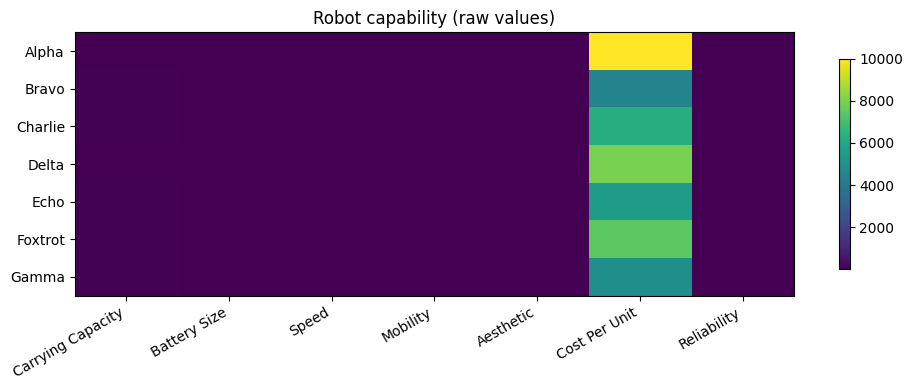

In [ ]:
def heatmap(dataframe, title, path=None):
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(dataframe.values, aspect="auto")
    ax.set_xticks(range(dataframe.shape[1]))
    ax.set_xticklabels(dataframe.columns, rotation=30, ha="right")
    ax.set_yticks(range(dataframe.shape[0]))
    ax.set_yticklabels(dataframe.index)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, shrink=0.8)
    fig.tight_layout()
    if path:
        fig.savefig(path, dpi=200)
    plt.show()

heatmap(df, "Robot capability (raw values)", path=os.path.join(OUT_DIR, "raw_heatmap.png"))


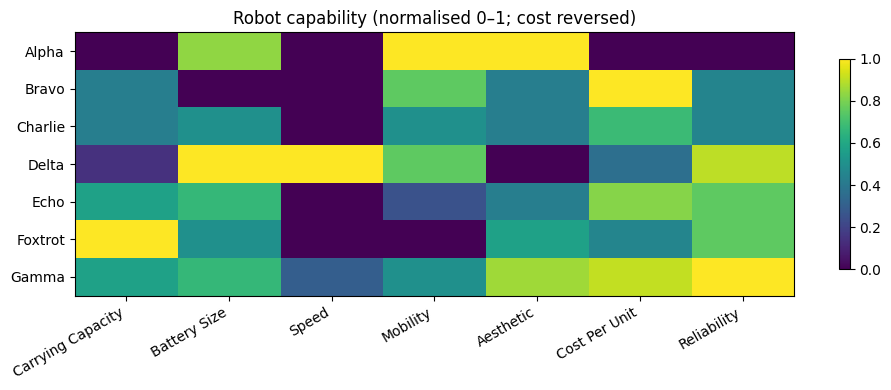

In [ ]:
heatmap(norm, "Robot capability (normalised 0–1; cost reversed)", path=os.path.join(OUT_DIR, "norm_heatmap.png"))

# Plan 1 weights (management model: scale & large shipments)

In [ ]:
w1_scores = {
    "Carrying Capacity": 10,
    "Cost Per Unit": 9,
    "Mobility": 6,
    "Speed": 6,
    "Battery Size": 5,
    "Reliability": 2,
    "Aesthetic": 1
}

w1 = np.array([w1_scores[c] for c in criteria], dtype=float)
w1 = w1 / w1.sum()

plan1_weights = pd.DataFrame({
    "Criterion": criteria,
    "Importance score (1–10)": [w1_scores[c] for c in criteria],
    "Weight (normalised)": w1
}).round(3)

display(plan1_weights)
print("Weights sum =", plan1_weights["Weight (normalised)"].sum())

,Criterion,Importance score (1–10),Weight (normalised)
0,Carrying Capacity,10,0.256
1,Battery Size,5,0.128
2,Speed,6,0.154
3,Mobility,6,0.154
4,Aesthetic,1,0.026
5,Cost Per Unit,9,0.231
6,Reliability,2,0.051


Weights sum = 1.0


# Plan 2 weights (IP strategy as a distribution, not single weights)

In [ ]:
mean_w2 = {
    "Battery Size": 0.30,
    "Cost Per Unit": 0.30,
    "Reliability": 0.25,
    "Carrying Capacity": 0.05,
    "Speed": 0.05,
    "Mobility": 0.03,
    "Aesthetic": 0.02
}

w2 = np.array([mean_w2[c] for c in criteria], dtype=float)

plan2_weights = pd.DataFrame({
    "Criterion": criteria,
    "Expected weight": w2
}).round(3)

display(plan2_weights)
print("Expected weights sum =", plan2_weights["Expected weight"].sum())

,Criterion,Expected weight
0,Carrying Capacity,0.05
1,Battery Size,0.30
2,Speed,0.05
3,Mobility,0.03
4,Aesthetic,0.02
5,Cost Per Unit,0.30
6,Reliability,0.25


Expected weights sum = 1.0


# Weighted Sum Model (WSM) scoring for both plans

In [ ]:
def wsm_scores(norm_df, weights, criteria_order):
    X = norm_df[criteria_order].values
    return pd.Series(X.dot(weights), index=norm_df.index)

plan1_wsm = wsm_scores(norm, w1, criteria).sort_values(ascending=False)
plan2_wsm = wsm_scores(norm, w2, criteria).sort_values(ascending=False)

display(pd.DataFrame({"Plan 1 WSM": plan1_wsm, "Plan 2 WSM": plan2_wsm}).round(4))

,Plan 1 WSM,Plan 2 WSM
Robot_Prototype,,
Alpha,0.2863,0.3000
Bravo,0.4901,0.4650
Charlie,0.4423,0.5120
Delta,0.5641,0.7137
Echo,0.5087,0.6776
Foxtrot,0.4785,0.5353
Gamma,0.6381,0.7984


# Plot WSM rankings

In [ ]:
def barplot(series, title, ylabel="Score", path=None):
    fig, ax = plt.subplots(figsize=(7, 4))
    series.plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Robot")
    fig.tight_layout()
    if path:
        fig.savefig(path, dpi=200)
    plt.show()


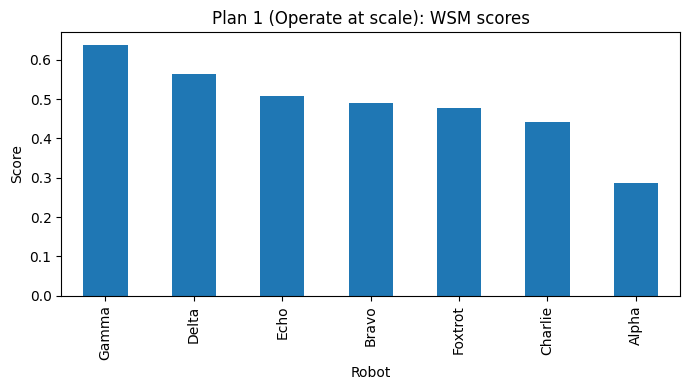

In [ ]:
barplot(plan1_wsm, "Plan 1 (Operate at scale): WSM scores", path=os.path.join(OUT_DIR, "plan1_wsm.png"))

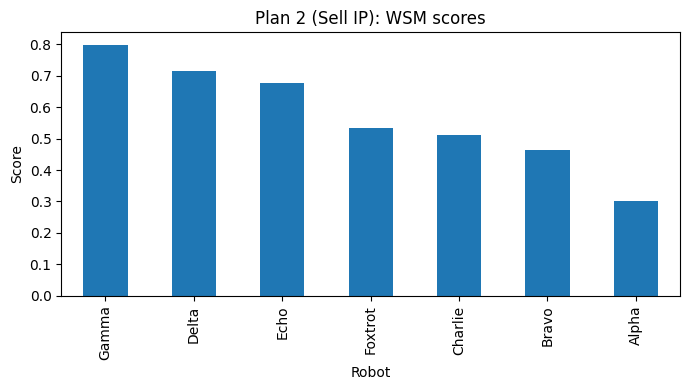

In [ ]:
barplot(plan2_wsm, "Plan 2 (Sell IP): WSM scores", path=os.path.join(OUT_DIR, "plan2_wsm.png"))

# TOPSIS (robustness check)

In [ ]:
def topsis(norm_df, weights, criteria_order):
    X = norm_df[criteria_order].values
    V = X * weights

    ideal = V.max(axis=0)
    nadir = V.min(axis=0)

    d_pos = np.sqrt(((V - ideal) ** 2).sum(axis=1))
    d_neg = np.sqrt(((V - nadir) ** 2).sum(axis=1))

    score = d_neg / (d_pos + d_neg)
    return pd.Series(score, index=norm_df.index).sort_values(ascending=False)

plan1_topsis = topsis(norm, w1, criteria)
plan2_topsis = topsis(norm, w2, criteria)

display(pd.DataFrame({"Plan 1 TOPSIS": plan1_topsis, "Plan 2 TOPSIS": plan2_topsis}).round(4))

,Plan 1 TOPSIS,Plan 2 TOPSIS
Robot_Prototype,,
Alpha,0.3312,0.3871
Bravo,0.5266,0.4899
Charlie,0.4677,0.5450
Delta,0.4851,0.6653
Echo,0.5301,0.7207
Foxtrot,0.5250,0.5413
Gamma,0.6187,0.7897


# Plan 1 - robustness via Monte Carlo (respecting “ordering constraints”)

In [ ]:
rng = np.random.default_rng(1)

def sample_plan1_weights(n=20000):
    W = []
    for _ in range(n):
        # Mobility anchor ~ 6/10, speed equal importance
        mobility = rng.uniform(5, 7)
        speed = mobility + rng.uniform(-0.2, 0.2)

        # Reliability slightly above aesthetic, but both low
        reliability = rng.uniform(1.2, 3.0)
        aesthetic = rng.uniform(0.5, reliability - 0.1)

        # Battery between reliability and mobility
        battery = rng.uniform(reliability + 0.1, mobility - 0.1)

        # Cost second-highest, capacity highest
        cost = rng.uniform(7.5, 9.5)
        capacity = rng.uniform(cost + 0.1, 10.5)

        scores = {
            "Carrying Capacity": capacity,
            "Battery Size": battery,
            "Speed": speed,
            "Mobility": mobility,
            "Aesthetic": aesthetic,
            "Cost Per Unit": cost,
            "Reliability": reliability
        }

        vec = np.array([scores[c] for c in criteria], dtype=float)
        vec = vec / vec.sum()
        W.append(vec)

    return np.array(W)

n_draws = 20000
W_samples = sample_plan1_weights(n_draws)

scores1 = W_samples.dot(norm[criteria].values.T)
winners1 = norm.index.values[np.argmax(scores1, axis=1)]

win_prob1 = pd.Series(winners1).value_counts(normalize=True).reindex(norm.index).fillna(0).sort_values(ascending=False)
display(win_prob1.rename("P(rank #1)").to_frame().round(4))

,P(rank #1)
Robot_Prototype,
Gamma,0.9994
Delta,0.0006
Alpha,0.0000
Charlie,0.0000
Bravo,0.0000
Echo,0.0000
Foxtrot,0.0000


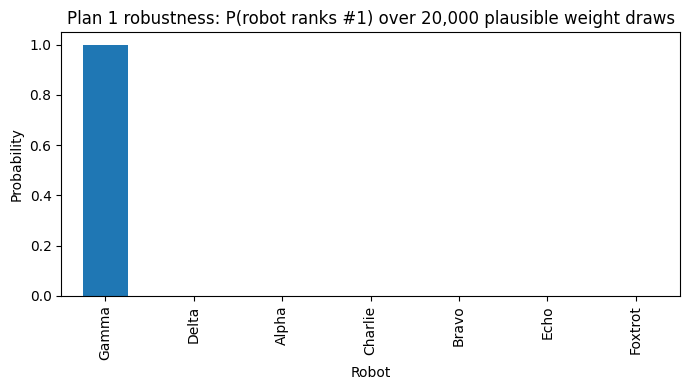

In [ ]:
barplot(win_prob1, f"Plan 1 robustness: P(robot ranks #1) over {n_draws:,} plausible weight draws",
        ylabel="Probability", path=os.path.join(OUT_DIR, "plan1_winprob.png"))

# Plan 2 - robustness via Monte Carlo (Dirichlet weight uncertainty)

In [ ]:
rng = np.random.default_rng(42)

# Concentration controls how "tight" the distribution is around the expected weights
alpha0 = 50  # higher => less variance around expected
alpha = np.array([mean_w2[c] * alpha0 for c in criteria])

n_draws = 20000
samples = rng.dirichlet(alpha, size=n_draws)

X = norm[criteria].values
scores = samples.dot(X.T)                  # shape: (draws, robots)
winners = norm.index.values[np.argmax(scores, axis=1)]

win_prob2 = pd.Series(winners).value_counts(normalize=True).reindex(norm.index).fillna(0).sort_values(ascending=False)
display(win_prob2.rename("P(rank #1)").to_frame().round(4))


,P(rank #1)
Robot_Prototype,
Gamma,0.9276
Delta,0.0724
Alpha,0.0000
Charlie,0.0000
Bravo,0.0000
Echo,0.0000
Foxtrot,0.0000


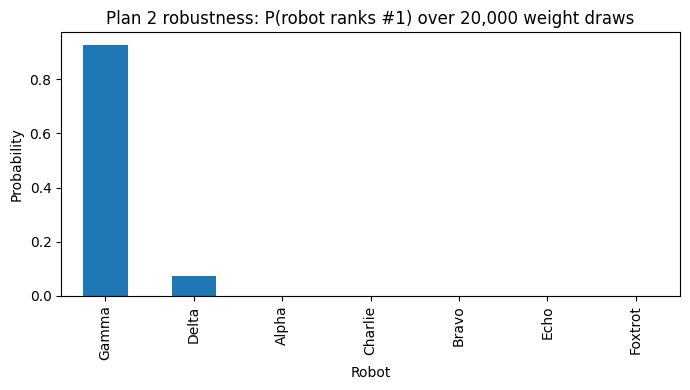

In [ ]:
barplot(win_prob2, f"Plan 2 robustness: P(robot ranks #1) over {n_draws:,} weight draws",
        ylabel="Probability", path=os.path.join(OUT_DIR, "plan2_winprob.png"))

# Final recommendations

In [ ]:
print("=== PLAN 1 (Operate at scale / large shipments) ===")
print("WSM top:", plan1_wsm.index[0], "| score:", round(plan1_wsm.iloc[0], 4))
print("TOPSIS top:", plan1_topsis.index[0], "| score:", round(plan1_topsis.iloc[0], 4))
print("Robustness winner (most often #1):", win_prob1.index[0], "| P:", round(win_prob1.iloc[0], 4))

print("\n=== PLAN 2 (Sell IP / battery+cost+reliability) ===")
print("WSM top:", plan2_wsm.index[0], "| score:", round(plan2_wsm.iloc[0], 4))
print("TOPSIS top:", plan2_topsis.index[0], "| score:", round(plan2_topsis.iloc[0], 4))
print("Robustness winner (most often #1):", win_prob2.index[0], "| P:", round(win_prob2.iloc[0], 4))

print("\nSuggested trial pair (2 robots):")
print("Plan 1 robot:", plan1_wsm.index[0])
print("Plan 2 robot (complementary learning):", plan2_wsm.index[1] if plan2_wsm.index[0] == plan1_wsm.index[0] else plan2_wsm.index[0])

=== PLAN 1 (Operate at scale / large shipments) ===
WSM top: Gamma | score: 0.6381
TOPSIS top: Gamma | score: 0.6187
Robustness winner (most often #1): Gamma | P: 0.9994

=== PLAN 2 (Sell IP / battery+cost+reliability) ===
WSM top: Gamma | score: 0.7984
TOPSIS top: Gamma | score: 0.7897
Robustness winner (most often #1): Gamma | P: 0.9276

Suggested trial pair (2 robots):
Plan 1 robot: Gamma
Plan 2 robot (complementary learning): Delta
